# Plot the Ekman pumping 

In [35]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [36]:
# Read the Ekman pumping data from 
# G. Meneghello, J. Marshall, M.-L. Timmermans and J. Scott (2018) 
# Observations of seasonal upwelling and downwelling in the Beaufort Sea mediated by sea ice. J. Phys. Oceanogr., 48(4), 
# doi:795-805 10.1175/JPO-D-17-0188.1"
data = xr.open_dataset('ArcticEkmanPumping.nc')

In [86]:
# Print the last months of 2014 and begening of 2015, since 2015 has only 1 week data 
data.time[-10:]

<xarray.DataArray 'time' (time: 10)>
array(['2014-11-02T00:00:00.000000000', '2014-11-09T00:00:00.000000000',
       '2014-11-16T00:00:00.000000000', '2014-11-23T00:00:00.000000000',
       '2014-11-30T00:00:00.000000000', '2014-12-07T00:00:00.000000000',
       '2014-12-14T00:00:00.000000000', '2014-12-21T00:00:00.000000000',
       '2014-12-28T00:00:00.000000000', '2015-01-04T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-11-02 2014-11-09 ... 2015-01-04

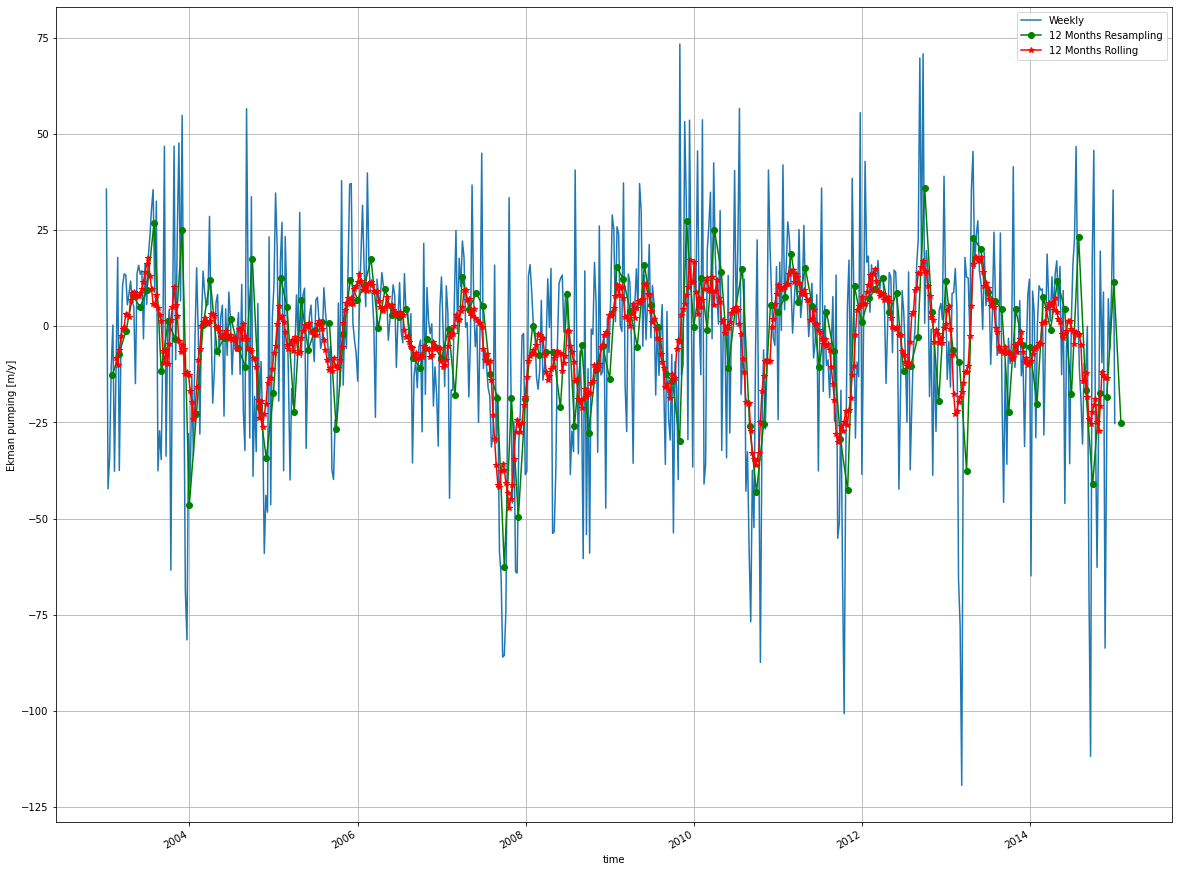

In [116]:
lonMooring = -150
dlon = 4
latMooring = 75
dlat = 1

# COmpute a spatial mean over the Beaufort Gyre (in a special way, I should admint)
weMooring = (3600*24*365*data.we.where( (abs( data.lat - latMooring ) < dlat) & (abs( data.lon - lonMooring ) < dlon) )).mean('i')
# Then perform a monthly mean WARNING: the associated time is located at the end of each month, it's not centered
weMooringMonth=weMooring.resample(time='1M').mean(dim='time')
# Or perfrom a 12 months rolling mean
weMooringMonthRoll=weMooring.rolling(time=12,center=True).mean()

plt.figure(figsize=(20,15))
weMooring.plot(label='Weekly')
weMooringMonth.plot(marker='o',color='g',label='12 Months Resampling')
weMooringMonthRoll.plot(marker='*',color='r',label='12 Months Rolling')
plt.ylabel('Ekman pumping [m/y]')
plt.grid(True)
plt.legend()

#savefig('Ekmann_Pumping.pdf')

# Perform a monthly mean 'by hand'

In [74]:
weMooringMonthHand=[]  ;  full_time=[]
for label in np.arange(2003,2015): # Remove the 1st week of year 2015 for facility
    print("year", label)
    # Select each year individualy 
    gb_year=weMooring.sel(time=str(label))
    # Perform a monthly mean with weekly values
    gb_month=gb_year.groupby('time.month').mean('time')
    weMooringMonthHand=np.append(weMooringMonthHand,gb_month)


year 2003
year 2004
year 2005
year 2006
year 2007
year 2008
year 2009
year 2010
year 2011
year 2012
year 2013
year 2014


In [75]:
# Define a proper time axis with monthly values 
full_time=pd.date_range(start='2003-01',end='2014-12',freq='MS')+ pd.DateOffset(days=14)
full_time

DatetimeIndex(['2003-01-15', '2003-02-15', '2003-03-15', '2003-04-15',
               '2003-05-15', '2003-06-15', '2003-07-15', '2003-08-15',
               '2003-09-15', '2003-10-15',
               ...
               '2014-03-15', '2014-04-15', '2014-05-15', '2014-06-15',
               '2014-07-15', '2014-08-15', '2014-09-15', '2014-10-15',
               '2014-11-15', '2014-12-15'],
              dtype='datetime64[ns]', length=144, freq=None)

In [76]:
# Save data 
ds_out=xr.Dataset()
ds_out['weMooringMonth']=(('time'),weMooringMonthHand)
ds_out['time']=full_time
if False: ds_out.to_netcdf('ArcticEkmanPumping_MonthlyMean.nc')

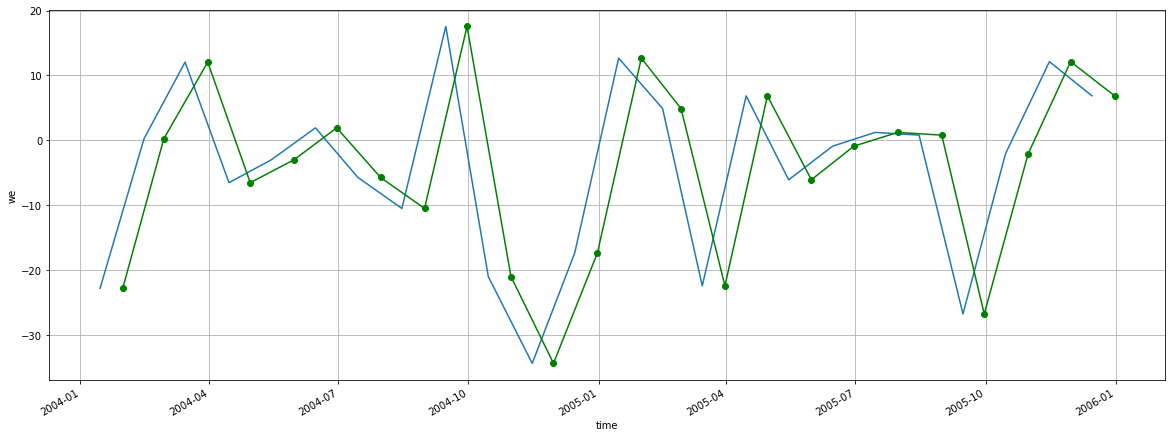

In [114]:
plt.figure(figsize=(20,15))
plt.subplot(211)
ds_out['weMooringMonth'].sel(time=slice('2004-01','2005-12')).plot()
weMooring.resample(time='1M').mean(dim='time').sel(time=slice('2004-01','2005-12')).plot(marker='o',color='g')
plt.grid(True)

>>>>> # Toy to play with groupby

In [40]:
toto=weMooring.groupby('time.year')
list(toto)

[(2003,
  <xarray.DataArray 'we' (time: 52)>
  array([ 35.67649695, -42.26601879, -33.82371154, -10.4990653 ,
           0.29896486, -37.71704125,  -9.40641781,  17.90833327,
         -37.49703149,  -6.03515605,  10.4255167 ,  13.61322949,
          13.33667831,   5.57829183,   8.42136921,  11.7368128 ,
           6.62964653,   5.01688969, -14.9170819 ,  13.70199158,
          15.84921443,  13.52577931,  14.46445176,  -3.29056987,
          16.36959424,   5.68589489,  18.22364709,  23.41916476,
          30.54658866,  35.52636589,   8.76854166,  32.54602912,
         -37.62796635, -27.17904115, -34.6728045 ,  -5.7585033 ,
          46.82220463, -33.78027529,  -2.14031673,   4.46963076,
         -63.42097797,  -1.31986156,  46.85170599,  -8.69595748,
          24.31076531,  47.6756792 ,   6.59167708,  54.84047771,
          -8.08655176, -68.860482  , -81.56110765, -27.89322198])
  Coordinates:
    * time     (time) datetime64[ns] 2003-01-05 2003-01-12 ... 2003-12-28),
 (2004,
  <xarray.

In [126]:
# The way to acces either a specific group or an array
for group_name, group_da in toto:
    
    print(group_name)
    print(group_da)
    print(group_da.time)
    # stop iterating after the first loop
    break

2003
<xarray.DataArray 'we' (time: 52)>
array([ 35.67649695, -42.26601879, -33.82371154, -10.4990653 ,
         0.29896486, -37.71704125,  -9.40641781,  17.90833327,
       -37.49703149,  -6.03515605,  10.4255167 ,  13.61322949,
        13.33667831,   5.57829183,   8.42136921,  11.7368128 ,
         6.62964653,   5.01688969, -14.9170819 ,  13.70199158,
        15.84921443,  13.52577931,  14.46445176,  -3.29056987,
        16.36959424,   5.68589489,  18.22364709,  23.41916476,
        30.54658866,  35.52636589,   8.76854166,  32.54602912,
       -37.62796635, -27.17904115, -34.6728045 ,  -5.7585033 ,
        46.82220463, -33.78027529,  -2.14031673,   4.46963076,
       -63.42097797,  -1.31986156,  46.85170599,  -8.69595748,
        24.31076531,  47.6756792 ,   6.59167708,  54.84047771,
        -8.08655176, -68.860482  , -81.56110765, -27.89322198])
Coordinates:
  * time     (time) datetime64[ns] 2003-01-05 2003-01-12 ... 2003-12-28
<xarray.DataArray 'time' (time: 52)>
array(['2003-01-05